In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from skopt import BayesSearchCV
from tqdm import tqdm_notebook as tqdm
from reed import *
from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
import pickle
import time

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
%matplotlib inline

%load_ext autoreload
%autoreload 2

sklearn.__version__

'0.24.2'

In [2]:
outcome = 'y_Dwsce'#'y_wsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=False
cross_val_cache = "data/cross-val-all.pkl"
bootstrap_cache = "data/bootstrap-all.pkl"

In [3]:
data = pd.read_csv("all_vars.csv",index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
if log_outcome:
    data[outcome] = np.log(data[outcome]+data[outcome].min())

Dropped 592 rows missing treatment or outcome.


In [4]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor

def construct_models():
    models = [
        Model('ridge',Ridge(), 
              parameters = {
                  'alpha':np.logspace(-1,4,30)
              }
        ),
        Model('lasso',Lasso(),
              parameters = {
                  'alpha':np.logspace(-2,4,30)
              }
        ), 
        Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':[10,20,40,60,80],
                'learning_rate':np.logspace(-3,0,10),
                'min_samples_leaf':np.logspace(0,3,10).astype(int)
              }
        ),
    ]
    return models

In [5]:
# %load -s exclude_vars,seperate_and_transform_data direct_regression.py
def exclude_vars():
    """Return a list of variables that should not be included as features."""
    treatments = ['^reduhl$', '^rehllt$', '^redudl$', '^redufl$', '^redllt$', '^refllt$']
    outcomes = ['^rlwage$', '^mh$', '^mhbm$', '^wkhr$', '^y_']
    other = [
        '^p_rcom',
        '^p_rdf',
        '^p_cotrl',
        '^xwaveid$',
        'p_rcom18'  # ?
        '^aedcq',  # indicate studying at start - these people should already have been removed
        '^abnfsty',
        '^aedcqfpt',
        '^aedqstdy'
    ]
    exclude = treatments + outcomes + other
    return exclude

def seperate_and_transform_data(data, treatment, outcome):

    transform = Pipeline([
        ('impute_missing', SimpleImputer()),
        ('scale', StandardScaler()),
    ])

    exclude = exclude_vars()

    control, treated = treatment_control_split(data, treatment)
    features = regex_select(data.columns, exclude, exclude=True)
    X0, y0 = split_and_transform(control, features, outcome, transform)
    X1, y1 = split_and_transform(treated, features, outcome, transform)

    # construct the full dataset (remove ordering by treatment in case of any order dependance in fit)
    X = np.vstack((X0, X1))
    y = np.concatenate((y0, y1))
    indx = np.arange(len(y))
    np.random.shuffle(indx)
    X = X[indx, :]
    y = y[indx]

    return X0, X1, y0, y1, X, y, features


In [6]:
X0, X1, y0, y1, X, y, features = seperate_and_transform_data(data, treatment, outcome)
print("Number of features:",len(features))

Treated:773, Control:4181
Number of features: 638


In [7]:
# %load -s print_unconditional_effects direct_regression.py
def print_unconditional_effects(data, treatment, y0, y1):
    print(f"Proportion Treated:{100*data[treatment].mean():.0f}%")
    print(f"Average outcome under Control:{y0.mean():.2f}±{y0.std()/np.sqrt(len(y0)):.2f}")
    print(f"Average outcome under Treatment:{y1.mean():.2f}±{y1.std()/np.sqrt(len(y1)):.2f}")
    print(f"Unadjusted treatment estimate {y1.mean() - y0.mean():.2f}")


In [8]:
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:16%
Average outcome under Control:76.98±14.61
Average outcome under Treatment:425.08±37.85
Unadjusted treatment estimate 348.10


In [9]:
# %load -s nested_cross_val direct_regression.py
def nested_cross_val2(
    construct_models,
    cache_name,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=None,
    outercv=None,
    load_from_cache=False,
):
    if load_from_cache:
        with open(cache_name, 'rb') as f:
            models, results = pickle.load(f)

    else:
        models = construct_models()
        results = {}
        for model in models:
            print(f"Fitting {model.name} ...", end='')
            results0 = model.nested_cv_fit_evaluate(
                X0, y0, optimisation_metric, evaluation_metrics,
                inner_cv=innercv, outer_cv=outercv)
            results1 = model.nested_cv_fit_evaluate(
                X1, y1, optimisation_metric, evaluation_metrics,
                inner_cv=innercv, outer_cv=outercv)
            results[model.name] = (results0, results1)
            print("Done")

        print(f"Caching results to {cache_name}")
        with open(cache_name, 'wb') as f:
            pickle.dump((models, results), f)

    return models, results


In [10]:
models, results = nested_cross_val2(
    construct_models,
    cross_val_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=3,
    outercv=4,
    load_from_cache=False)

Fitting ridge ...Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Done
Fitting lasso ...Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Fitting 3 folds for each of 30 candidates, totalling 90 fits


Done
Fitting gbr ...Fitting 3 folds for each of 500 candidates, totalling 1500 fits


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


Fitting 3 folds for each of 500 candidates, totalling 1500 fits


Done
Caching results to data/cross-val-all.pkl


In [11]:
def estimate_causal_effect(X, models0, models1):
    tau = []
    for e0, e1 in zip(models0,models1):
        y0 = e0.predict(X)
        y1 = e1.predict(X)
        tau.append(y1-y0)
    
    # array of shape len(modelsi),len(X)
    cate = np.array(tau) 
    
    # array of shape len(modelsi) with the ate estimate for each sample
    ate = np.mean(cate,axis=1) 
    return ate

rows = []
index = []
for model_name, r in results.items():
    tau = estimate_causal_effect(X, r[0]['estimator'],r[1]['estimator'])
    row = {'ACE':tau.mean(),'ACE_std':tau.std()}
    for m in evaluation_metrics:
        key = f'test_{m}'
        for name, result in zip(('control','treated'),r):
            label=f"{name}_{m}"
            label_std=f"{label}_std"
            row[label]= result[key].mean()
            std = result[key].std()
            row[label_std] = result[key].std()
    rows.append(row)
    index.append(model_name)
metrics = pd.DataFrame(rows,index=index)

with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(metrics)

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
ridge,347.42,22.93,0.21,0.02,0.10,0.04,"-704,484.48","72,754.68","-1,005,507.26","272,704.91"
lasso,347.47,25.08,0.24,0.04,0.12,0.03,"-679,370.10","70,206.73","-973,808.90","252,049.28"
gbr,314.59,47.30,0.25,0.02,0.11,0.04,"-663,563.10","59,270.09","-987,477.23","261,066.24"


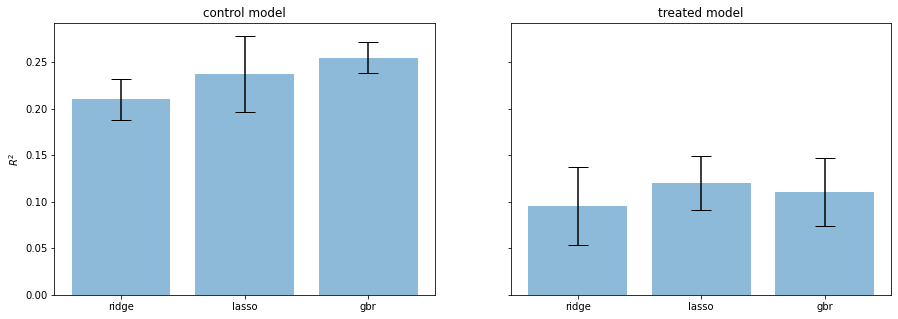

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
ax[0].bar(metrics.index, metrics['control_r2'], yerr=metrics['control_r2_std'], align='center', alpha=0.5, capsize=10)
ax[1].bar(metrics.index, metrics['treated_r2'], yerr=metrics['treated_r2_std'], align='center', alpha=0.5,capsize=10)
ax[0].set_ylabel('$R^2$')
ax[0].set_title('control model')
ax[1].set_title('treated model');

In [13]:
def get_coef(estimator):
    e = estimator
    if hasattr(estimator,'best_estimator_'):
        e = estimator.best_estimator_
    if hasattr(e,'coef_'):
        return e.coef_
    return None 

def coef_mean_std(estimator_lst):
    n_estimators = len(estimator_lst)
    coef = np.zeros((len(features),n_estimators))
    for i, e in enumerate(estimator_lst):
        coef[:,i] = get_coef(e)
    mu = coef.mean(axis=1)
    std = coef.std(axis=1)
    return mu, std

def display_top_coefficients(model_name, r):
    if get_coef(r[0]['estimator'][0]) is None:
        return
    with open('data/metadata.pkl','rb') as f:
        meta = pickle.load(f)
    
    contr, treat = r[0], r[1]
    coef_t_mu, coef_t_std = coef_mean_std(treat['estimator'])
    coef_c_mu, coef_c_std = coef_mean_std(contr['estimator'])
    coefs = pd.DataFrame({
        'feature':features,
        'coef0':coef_c_mu,
        'coef1':coef_t_mu
    })
    absv = np.vstack((coefs['coef0'].abs().values,coefs['coef1'].abs().values)).T
    coefs['importance'] = absv.max(axis=1)
    coefs['hetero'] = (coefs['coef1']-coefs['coef0']).abs()
    labels = coefs['feature'].apply(meta.column_names_to_labels.get)
    coefs.insert(0,'variable',labels)
    print(f'Feature Coefficients for: {model_name}')
    display(coefs.sort_values('importance',ascending=False).head(20))


In [14]:
for model_name, r in results.items():
    display_top_coefficients(model_name,r)

Feature Coefficients for: ridge


,variable,feature,coef0,coef1,importance,hetero
190,DV: Current weekly gross wages & salary - all ...,awscei,-84.188204,-25.513167,84.188204,58.675037
130,DV: Household current weekly gross wages & sal...,ahiwscei,-49.368396,-10.801079,49.368396,38.567317
300,G3 Total gross amount of most recent pay befor...,awscmga,-44.600967,6.081584,44.600967,50.682551
175,HF4 Year of Birth,ahgyob,43.598204,27.263369,43.598204,16.334836
443,DV: Time in paid work - years,aehtjb,-37.905849,-24.600939,37.905849,13.304911
275,E29 Percent chance will find and accept job at...,ajbmpgj,36.960818,-3.675214,36.960818,40.636032
456,DV: Age of oldest person in household,ahhold,-34.299580,-15.815207,34.299580,18.484373
361,H27 How likely to have a child/more children i...,aicexpct,30.114104,8.771828,30.114104,21.342276
2,DV: Age last birthday at June 30 2001 - person 01,ahgage1,-27.471891,-17.568377,27.471891,9.903514
360,H26 Like to have more children in the future,aiclike,25.411102,9.210344,25.411102,16.200758


Feature Coefficients for: lasso


,variable,feature,coef0,coef1,importance,hetero
190,DV: Current weekly gross wages & salary - all ...,awscei,-268.841027,-94.235208,268.841027,174.605819
175,HF4 Year of Birth,ahgyob,222.746900,176.379845,222.746900,46.367054
450,DV: Age youngest own child (excl. resident fos...,atcyng,0.000000,-66.425291,66.425291,66.425291
51,Q1 Any children aged 14 or less,acccinhh,-53.871549,0.000000,53.871549,53.871549
275,E29 Percent chance will find and accept job at...,ajbmpgj,53.251110,0.000000,53.251110,53.251110
361,H27 How likely to have a child/more children i...,aicexpct,53.117124,0.000000,53.117124,53.117124
308,G12 Check age and sex - currently eligible for...,abnage,-51.242365,0.000000,51.242365,51.242365
208,DV: Financial year estimated taxes on regular ...,atxtotn,0.000000,41.204794,41.204794,41.204794
434,DV: E13 Occupation 2-digit ASCO,ajbmocc2,-0.737719,-37.160796,37.160796,36.423077
349,H15b Age of child - Resident child 0001,arcage1,-10.393581,-35.312532,35.312532,24.918951


In [15]:
def extract_params(estimator):
    return estimator.coef_

def bootstrapped_cross_val(
    optimisation_metric,
    extract_params_func,
    inner_cv = 3,
    load_from_cache=False, 
    cache_name=bootstrap_cache, 
    samples=10
):
    if load_from_cache:
        with open(cache_name, 'rb') as f:
            results = pickle.load(f)
    else:
        models = construct_models()
        results = {}
        start = time.time()
        for model in models:
            print(f"Fitting {model.name} ...",end='')
            results0 = model.bootstrap_cv_evaluate(X0,y0,optimisation_metric,extract_params,
                                                   bootstrap_samples=samples,return_estimator=True)
            results1 = model.bootstrap_cv_evaluate(X1,y1,optimisation_metric,extract_params,
                                                   bootstrap_samples=samples,return_estimator=True)
            results[model.name] = (results0, results1)
            print("Done")
        total = time.time()-start
        print(f"Total time:{total} seconds")
        print(f"Caching results to: {cache_name}")
        with open(cache_name,'wb') as f:
            pickle.dump(results,f)
    
    return results

bootstrap_results = bootstrapped_cross_val(
    optimisation_metric, 
    extract_params,
    load_from_cache=False,
    samples=20
)

Fitting ridge ...Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Done
Fitting lasso ...Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Done
Fitting gbr ...Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Done
Total time:6501.582203626633 seconds
Caching results to: data/bootstrap-all.pkl


In [16]:
for model_name, (results0, results1) in bootstrap_results.items():
    models0 = [r['estimator'] for r in results0]
    models1 = [r['estimator'] for r in results1]
    ate = estimate_causal_effect(X,models0, models1)
    print(f'{model_name}, {ate.mean():.2f} ± {ate.std()/np.sqrt(len(ate)-1):.2f}')  

ridge, 343.67 ± 8.38


lasso, 356.33 ± 6.76


gbr, 350.96 ± 16.37


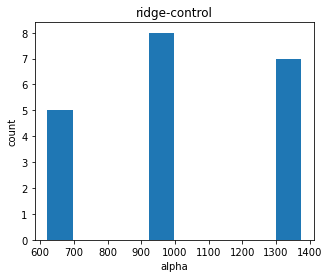

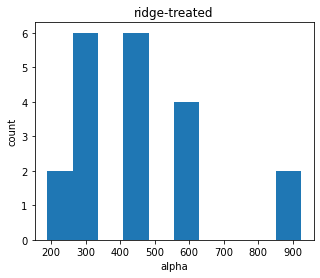

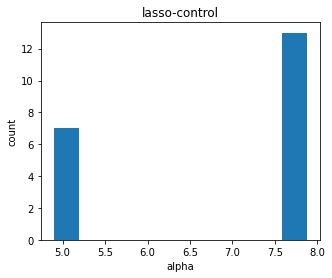

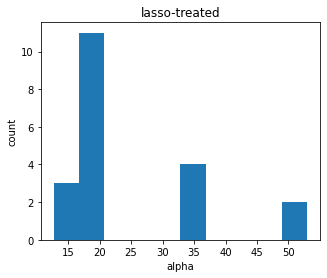

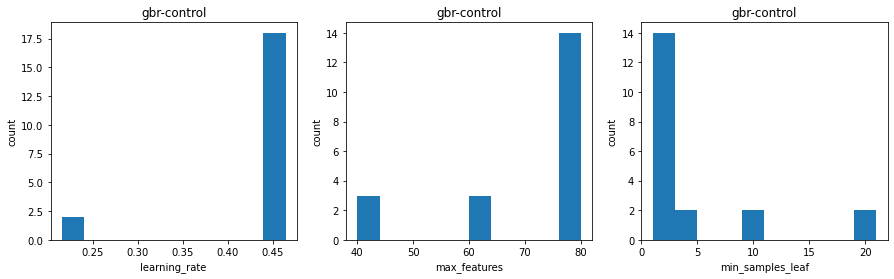

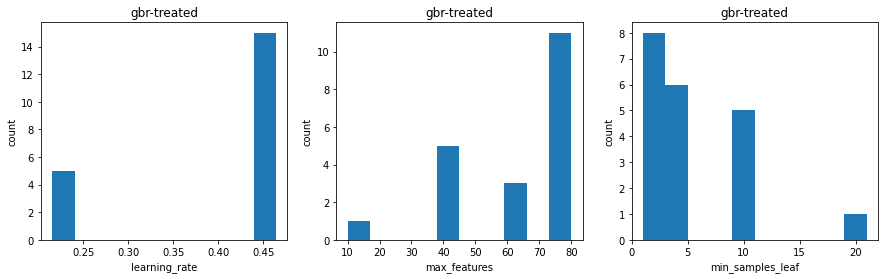

In [17]:
from collections import defaultdict
def hyperparam_distributions(samples) -> {str:[]}:
    """Returns a dict from hyper-parameter name to the best values for that hyper-parameter over the samples."""
    distributions = defaultdict(list)
    for sample in samples:
        h = sample['estimator'].best_params_
        for key, value in h.items():
            distributions[key].append(value)
    return distributions

def plot_hyperparam_distributions(samples, title) -> None:
    distributions = hyperparam_distributions(samples)
    k = len(distributions)
    fig, axes = plt.subplots(1,k,figsize=(k*5,4))
    if k == 1:
        axes = [axes]
    for i, (key, values) in enumerate(distributions.items()):
        ax = axes[i]
        ax.hist(values)
        ax.set_title(title)
        ax.set_xlabel(key)
        ax.set_ylabel('count')
    return fig,axes

for model, (results0, results1) in bootstrap_results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")